# Oracle check

## 入力状態作成

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import time 

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.tools.visualization import plot_histogram
import json
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [3]:
# 初期状態
mat = \
    np.array([[4, 0, 2, 0],
              [0, 1, 0, 4],
              [1, 0, 4, 0],
              [0, 4, 0, 2]])
mat_correct = \
    np.array([[4, 3, 2, 1],
              [2, 1, 3, 4],
              [1, 2, 4, 3],
              [3, 4, 1, 2]])

In [4]:
correct_ind = [3, 1, 2, 3, 2, 3, 3, 1]

In [5]:
correct_ind_bin = [1,0, 0,0, 0,1, 1,0, 0,1, 1,0, 1,0, 0,0]

In [14]:
# circuit construction 
n_qubits = 32
# n_qubits = 16
n_blanks = 8
n_cbits = 2 * n_blanks

q = QuantumRegister(n_qubits) 
c = ClassicalRegister(n_cbits)
circuit = QuantumCircuit(q, c)

In [11]:
# oracle

# if v1 != v2 (number) then target = 1 else target = 0
def compare_vertex(qc, qr, v1, v2, target):
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])
    #
    qc.x(qr[target])

def compare_vertex_inv(qc, qr, v1, v2, target):
    qc.x(qr[target])
    #
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])

# # とりあえず辺埋め込みオラクル
# def simple_oracle(qc, qr):
#     # vs = [0, 1, 2, 3, 4, 5, 6, 7]
#     lst = [[0, 1], [2, 3], [4, 5], [6, 7], [2, 6], [0, 4], [1, 5], [3, 7], [0, 2], [1, 3], [4, 6], [5, 7]]
#     target = 16
#     for elm in lst:
#         assert(len(elm)==2)
#         compare_vertex(qc, qr, elm[0], elm[1], target)
#         target+=1
#     assert(target<=29)
#     dst = 29
# #     qc.mct(qr[16:target], qr[dst], [], mode='noancilla')
#     for elm in (reversed(lst)):
#         target-=1
#         compare_vertex_inv(qc, qr, elm[0], elm[1], target)

# とりあえず辺埋め込みオラクル
def simple_oracle(qc, qr):
    # vs = [0, 1, 2, 3, 4, 5, 6, 7]
    lst1 = [[0, 1], [2, 3], [4, 5], [6, 7], [2, 6], [0, 4]]
    lst2 = [[1, 5], [3, 7], [0, 2], [1, 3], [4, 6], [5, 7]]
    target = 16
    tmp1 = 30
    tmp2 = 31
    for elm in lst1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp1], qr[22:29], mode='basic')
    for elm in (reversed(lst1)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
        
    for elm in lst2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp2], qr[22:29], mode='basic')
    for elm in (reversed(lst2)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
    
    ##
    dst = 29
    qc.ccx(qr[tmp1], qr[tmp2], qr[dst])
    ##
    
    for elm in lst2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp2], qr[22:29], mode='basic')
    for elm in (reversed(lst2)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
        
    for elm in lst1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp1], qr[22:29], mode='basic')
    for elm in (reversed(lst1)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)



In [12]:
# diffusion

# def diffusion(circuit, qr, template):
#     """
#     diffusion (inversion about the mean) circuit.
#     note that this implementation gives H^{\otimes n} (Id - |0..0><0...0|) H^{\otimes n}
#     :param circuit:
#     :param qr: QuantumRegister on blanks (ancillae not included)
#     :return:
#     """

#     # circuit.h(qr)
#     create_initial_inv(circuit, qr, mat)  # 初期状態準備のユニタリ操作のinverse
#     circuit.x(qr)

#     # apply multi-control CZ
#     circuit.h(qr[-1])
#     # circuit.mct(qr[:-1], qr[-1], anc, mode='basic')
#     circuit.mct(qr[:-1], qr[-1], [], mode='noancilla')  # ancilla使わないver
#     circuit.h(qr[-1])

#     circuit.x(qr)
#     # circuit.h(qr)
#     create_initial(circuit, qr, mat)
    
def diffusion(circuit, qr, mat):
    """
    diffusion (inversion about the mean) circuit.
    note that this implementation gives H^{\otimes n} (Id - |0..0><0...0|) H^{\otimes n}
    :param circuit:
    :param qr: QuantumRegister on nodes
    :return:
    """

    # circuit.h(qr)
    create_initial_inv(circuit, qr[:16], mat)  # 初期状態準備のユニタリ操作のinverse
    circuit.x(qr[:16])

    # apply multi-control CZ
    circuit.h(qr[15])
    # circuit.mct(qr[:-1], qr[-1], anc, mode='basic')
    circuit.mct(qr[:15], qr[15], qr[16:32], mode='basic')  # ancilla使うver
    circuit.h(qr[15])

    circuit.x(qr[:16])
    # circuit.h(qr)
    create_initial(circuit, qr[:16], mat)

In [13]:
# number of iteration
n_it = 1

def grover(circuit, q, c, mat):

    # set initial state
    create_initial(circuit, q[:16], mat)
    
    for _ in range(n_it):
        simple_oracle(circuit, q)
        diffusion(circuit, q, mat)
    
    circuit.barrier()
    
    # measurement
    circuit.measure(q[:n_cbits],c)

In [14]:
# circuit construction 
n_qubits = 32
# n_qubits = 16
n_blanks = 8
n_cbits = 2 * n_blanks

q = QuantumRegister(n_qubits) 
c = ClassicalRegister(n_cbits)
circuit = QuantumCircuit(q, c)

In [15]:
grover(circuit, q, c, mat)
print('circuit has been constructed!')

circuit has been constructed!


### Use Transpiler

In [ ]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In [ ]:
# https://qiskit.org/documentation/locale/ja/api/qiskit.compiler.transpile.html
optimized_circuit = transpile(circ, basis_gates=['u1', 'u3', 'u2', 'cx'], optimization_level=2) 

In [ ]:
### Execution
time0 = time.time()
# shots = 8000
shots = 100
print("shots:", shots)

## local simulator
# backend = Aer.get_backend('qasm_simulator')
## cloud simulator
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

# job = execute(circuit, backend=backend, shots=shots, seed_simulator=12345)
job = execute(optimized_circuit, backend=backend, shots=shots, seed_simulator=12345)  # to use transpiled circuit
# job = execute(circuit, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})

result = job.result()
count = result.get_counts()
time1 = time.time()
print(f"Calculations took {time1-time0} sec.")
print(count)

shots: 100


In [ ]:
plot_histogram(count)

In [ ]:
# サンプリング結果の最頻値
most_frequent = sorted(count.items(), key=lambda x:x[1], reverse=True)[0][0]

In [ ]:
# 10進数(1~4)に変換
def convert_to_decimal(str_bin):
    str_bin = ''.join(list(reversed(str_bin)))  # cbitに格納されるときに順番逆になっていることに注意
    list_dec = [int(str_bin[2*i:2*i+2], 2)+1 for i in range(len(str_bin)//2)]
    return list_dec

In [ ]:
solution = convert_to_decimal(most_frequent)
print(solution)

In [ ]:
for key, value in count.items():
    print(convert_to_decimal(key), f'count: {value}')

### validation


In [ ]:
mat_answer_filled = mat.copy()

# 回答で埋める
k = 0
for i in range(4):
    for j in range(4):
        if mat_answer_filled[i][j] == 0:
            mat_answer_filled[i][j] = solution[k]
            k += 1
            
mat_answer_filled = np.array(mat_answer_filled)

In [7]:
mat_answer_filled = np.array([[4, 3, 2, 1],
       [2, 1, 3, 4],
       [1, 2, 4, 3],
       [3, 4, 1, 2]])

In [16]:
# 10進数のリスト
ans_10_list = mat_answer_filled.flatten().tolist()
print(ans_10_list)

[4, 3, 2, 1, 2, 1, 3, 4, 1, 2, 4, 3, 3, 4, 1, 2]


In [15]:
def row_judge(ans_10_list):
    for i in range(0, 16, 4):
        if len(list(set(ans_10_list[i:i+4]))) < 4:
            return False
    return True

def colum_judge(ans_10_list):
    for i in range(0,4):
        get_colum = []
        for j in range(i,16,4):
            get_colum.append(ans_10_list[j])
        if len(list(set(get_colum))) < 4:
            return False
        else:
            pass
    return True

def box_judge(ans_10_list):
    split_ans = []
    for i in range(0, len(ans_10_list), 2):
        split_ans.append([ans_10_list[i], ans_10_list[i+1]])
    for i in range(0, 2):
        get_box = split_ans[i] + split_ans[i+2]
        if len(list(set(get_box))) < 4:
            return False
        else:
            pass
    for i in range(4, 6):
        get_box = split_ans[i] + split_ans[i+2]
        if len(list(set(get_box))) < 4:
            return False
        else:
            pass
    return True

def judge_whole(ans_10_list):
  
    judgeA = row_judge(ans_10_list)
    judgeB = colum_judge(ans_10_list)
    judgeC = box_judge(ans_10_list)
    
    return(judgeA and judgeB and judgeC)

[4, 3, 2, 1, 2, 1, 3, 4, 1, 2, 4, 3, 3, 4, 1, 2]


In [17]:
judge_whole(ans_10_list)

True

In [86]:
count = {'0000':10, '0001':5}

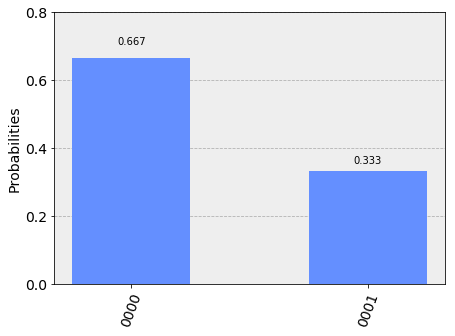

In [87]:
plot_histogram(count)

In [88]:
count_decimal = {}
for key, value in count.items():
    count_decimal[convert_to_decimal(key)] = value

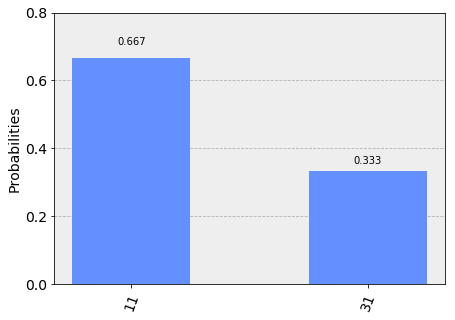

In [90]:
plot_histogram(count_decimal)

In [77]:
# サンプリング結果の最頻値
most_frequent = sorted(count.items(), key=lambda x:x[1], reverse=True)[0][0]

In [78]:
most_frequent

'0000'

In [79]:
list_dec = [1,1]

In [80]:
str(list_dec)

'[1, 1]'

In [81]:
# 10進数(1~4)に変換
def convert_to_decimal(str_bin):
    str_bin = ''.join(list(reversed(str_bin)))  # cbitに格納されるときに順番逆になっていることに注意
    list_dec = [str(int(str_bin[2*i:2*i+2], 2)+1) for i in range(len(str_bin)//2)]
    str_dec = ''.join(list_dec)
    return str_dec

In [82]:
solution = convert_to_decimal(most_frequent)
print(solution)

11


In [83]:
for key, value in count.items():
    print(convert_to_decimal(key), f'count: {value}')

11 count: 10
31 count: 5


In [101]:
import pickle
with open('count.pkl', 'wb') as pkl:
    pickle.dump(count , pkl)

In [102]:
with open('count.pkl', 'rb') as pkl:
    count_from_pkl = pickle.load(pkl)
    print(count_from_pkl)

{'0000': 10, '0001': 5}
